# Intelligent Systems - Individual Project Assessment
I aim to split the code into 3 sections:
1. Generating and analysing the datset
2. Developing my classification model
3. Training my model

In [127]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import v2
import torchvision
from torch.nn import functional as F
import scipy

torch.manual_seed(30)
torch.cuda.empty_cache()

In [128]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if (torch.cuda.is_available()):
  print(torch.cuda.get_device_name(device))
# torch.set_default_device(device)

Using device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


# Dataset
## Downloading and splitting the dataset
First, let's look at what data we're working with:

In [129]:
train_dataset = datasets.Flowers102(
    root = 'flowers-102/train',
    split='train',
    download=True,
)
val_dataset = datasets.Flowers102(
    root = 'flowers-102/val',
    split='val',
    download=True,
)
test_dataset = datasets.Flowers102(
    root = 'flowers-102/test',
    split='test',
    download=True,
)

<PIL.Image.Image image mode=RGB size=754x500 at 0x1F7C6064170>


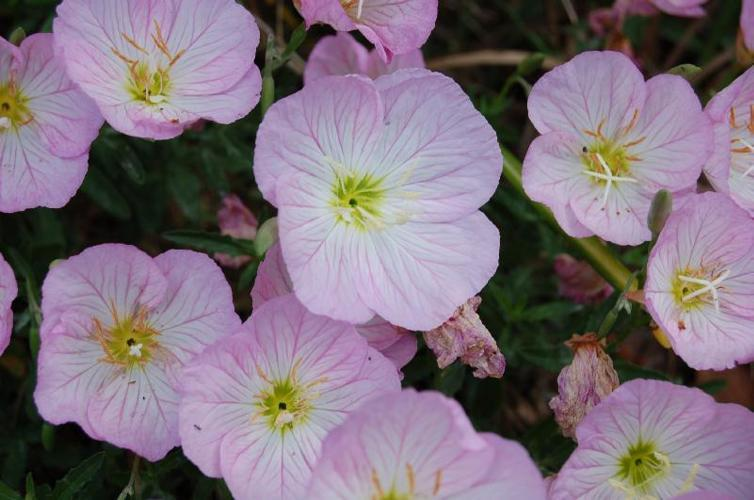

In [130]:
image, label = train_dataset[0]

print(image)
image

We can see that the images are PIL formatted

In [131]:
from random import randint


def img_grid(cols, rows, title, lbl=None, tf=None):
    if lbl is not None:
        indices = [id for id, target in enumerate(train_dataset._labels) if target == lbl]
        dataset = Subset(train_dataset, indices)
    else:
        dataset = train_dataset
    fig = plt.figure(figsize=(10, 10))
    for i in range(1, cols*rows+1):
        idx = randint(0, len(dataset)-1)
        img, label = dataset[idx]
        fig.add_subplot(rows, cols, i)
        if lbl is None:
            plt.title(label)
        plt.axis("off")
        if tf is not None:
            img = tf(img)
        else:
            img = v2.functional.pil_to_tensor(img)
        plt.imshow(img.cpu().permute(1, 2, 0))
        fig.suptitle(title)
    plt.show()

In [132]:
image, label = train_dataset[0]

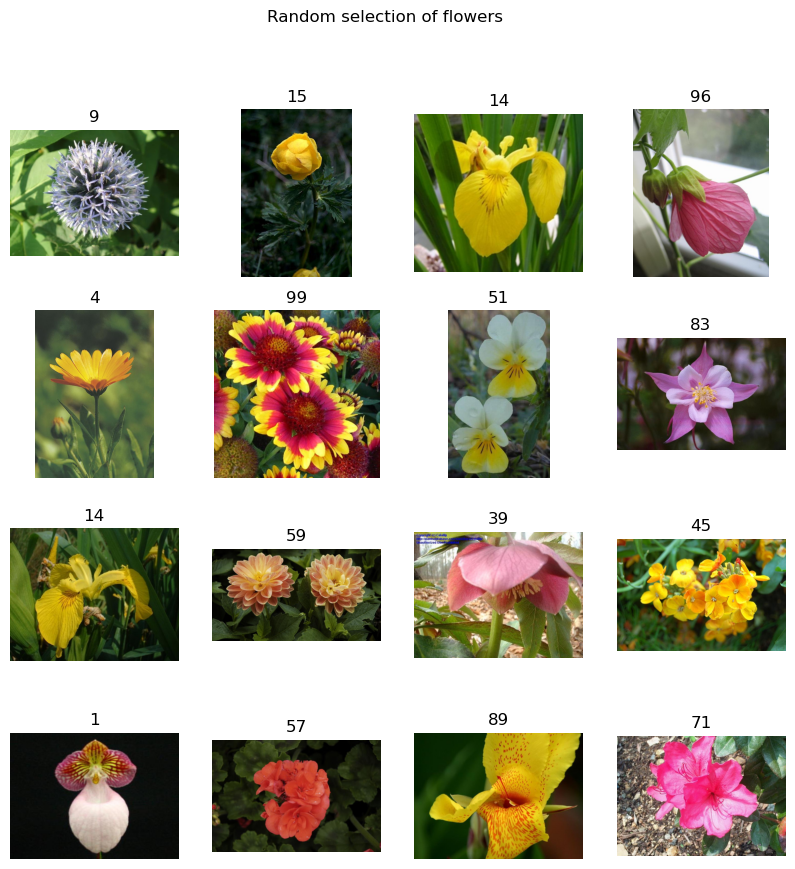

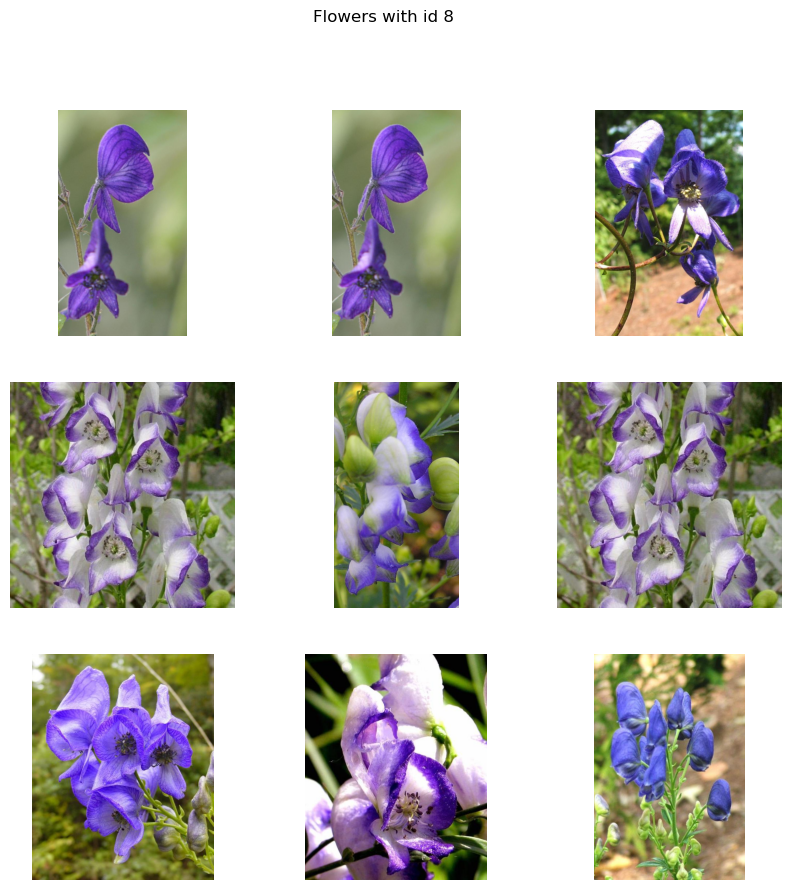

In [133]:
img_grid(4, 4, "Random selection of flowers")

label = 8
img_grid(3, 3, f"Flowers with id {label}", label)

## Data Augmentation Techniques - Transforms
We can `compose` transformations together. It appears that they use `transforms.ToTensor()` at the end.
See here for a list of all the transformations: https://pytorch.org/vision/0.9/transforms.html

As I am making my own model, not fine-tuning, I will use the Flowers-102's normalisation values 

In [134]:
# Get the mean and standard deviation values for my dataset
# Get the whole dataset
# from numpy import dtype, float32


# data = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])
# mean = 0.
# std = 0.
# tf = v2.Compose([
#     v2.ToImage(),
#     v2.ToDtype(torch.uint8, scale=True),
#     v2.Resize(size=(224, 224)),
#     v2.ToDtype(torch.float32, scale=True),
# ])

# for image, _ in data:
#     tImg = tf(image)
#     mean += torch.mean(tImg, dim=(1, 2))
#     std += torch.std(tImg, dim=(1, 2))
# mean /= len(data)
# std /= len(data)
# print(f"Mean: {mean}\nStandard Deviation: {std}")

### OUTPUT ###
# Mean: tensor([0.4355, 0.3777, 0.2879], device='cuda:0')
# Standard Deviation: tensor([0.2620, 0.2086, 0.2156], device='cuda:0')
flowers_normalise = v2.Normalize(mean=[0.4355, 0.3777, 0.2879], std=[0.229, 0.224, 0.225]),
### IMAGENET NORMALISATION ###
# Mean: tensor([0.485, 0.456, 0.406])
# Standard Deviation: tensor([0.229, 0.224, 0.225])
imagenet_normalise = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8674972..3.0777433].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9017466..3.164889].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9017466..3.164889].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8332477..2.778125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4222535..3.164889].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9017466..3.1474602].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6861607..2.778125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7304991..3.

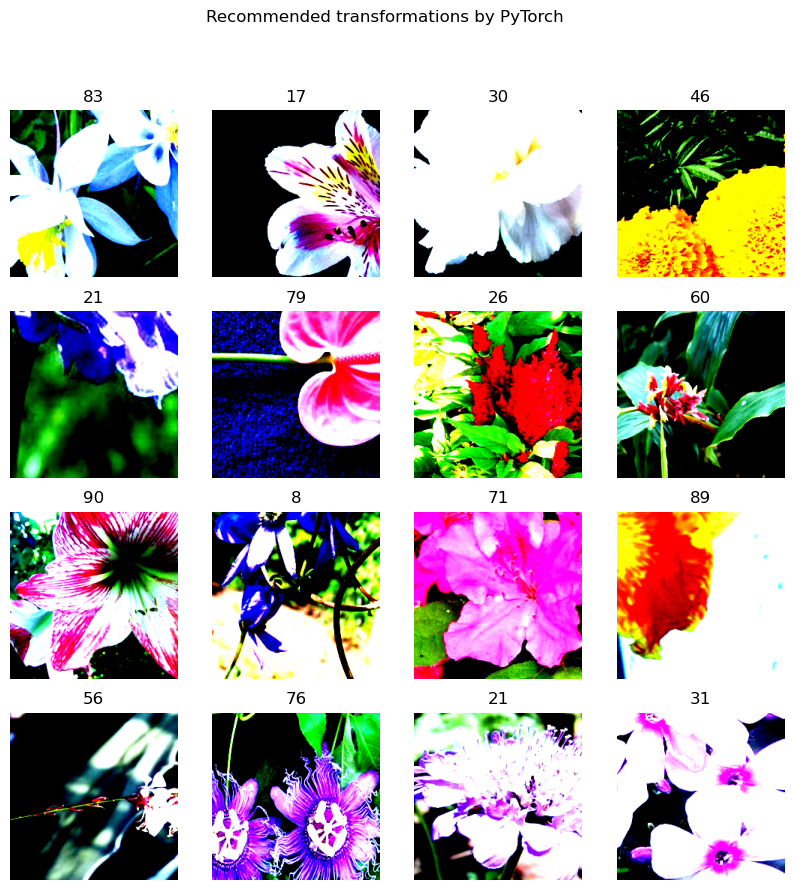

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.884622..2.7291596].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6861607..2.638069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9017466..3.164889].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.679125..3.164889].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8503724..2.6205623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8674972..3.0951724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9017466..2.

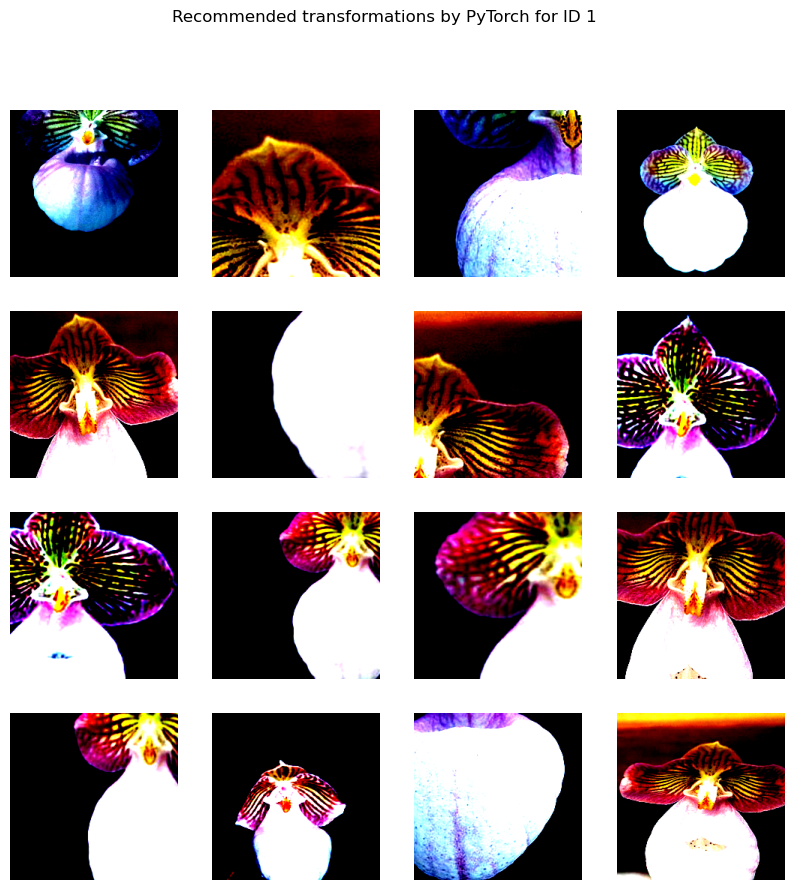

In [135]:
# Basic image classificatin suggestion from PyTorch
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4355, 0.3777, 0.2879], std=[0.229, 0.224, 0.225]),
])

img_grid(4, 4, "Recommended transformations by PyTorch", tf=transforms)
img_grid(4, 4, f"Recommended transformations by PyTorch for ID {1}", lbl=1, tf=transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8106424..2.3816388].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8106424..3.1573632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8106424..3.284687].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8106424..3.3028758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8106424..2.8299594].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8106424..3.3028758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8106424

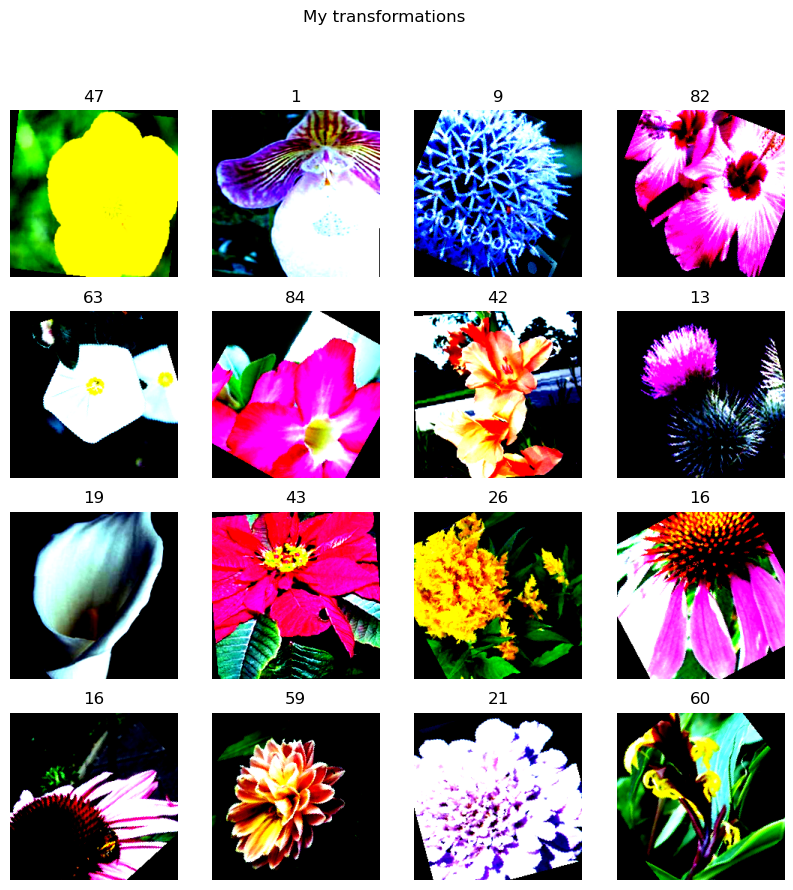

In [136]:
# My data augmentation process
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomResizedCrop(size=(224, 224), antialias=True, scale=(0.3, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(45),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4355, 0.3777, 0.2879], std=[0.2620, 0.2086, 0.2156]),
])

img_grid(4, 4, "My transformations", tf=transforms)